In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

#### Imports for AdaBoost

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

## Boosting

 
* A general approach that can be applied to many statistical learning methods for regression or classification. 
* Not a learning method, it boosts performance of other learning methods such as decision trees, linear regression, etc.
* An ensemble method, it sequentially combines base learners to improve performance
* Not prone to overfitting
    - Empirical result
    - Can overfit but not as much as other methods
* Boosting is a method of combining a sequence of **Weak Learners** $h_i$ into a strong learner H
    - Each weak learner gets a vote in determining the final result
    
<div style="font-size: 110%;">
$$H(x) = sign(\alpha_1h_1(x) + \alpha_2h_2(x) + ... + \alpha_nh_n(x))$$
</div>

* H(x) is the final ensemble learner
* $h_i(x)$ is a weak learner
* $\alpha_i$ is the voting power of weak learner $h_i$

![](MisClassArea1.png)
$$\text{Figure 1. Weak Learners. Shaded area is the area where the learner misclassifies the samples}$$

#### Weak Learner
 
* A learning algorithm that performs slightly better than chance
    - e.g. a tree with one split, called a stump
* Each weak learner misclassifies samples in part of the space (see Figure 1)

#### Error rate

![](ErrorRate.png)
$$\text{Figure 2. Error Rates for Learners}$$

#### Emphasize data points that have been misclassified.

* In each iteration focus on data points that were misclassified in the previous round
    - Weighting
    - Sampling

#### Different Types of Boosting Algorithm

* Adaptive Boosting (AdaBoost, Freund and Schapire (1997))
    - sklearn
* Gradient Boosting
    - sklearn
    - XGBoost (2014)
    - Catboost (2017)

### ADABoost (Adaptive Boosting)

* Freund and Schapire (1996)
    - Godel Prize (2003)
    
* Any machine learner that accepts weights on training data can be used as the base learner  
* Most often applied to Trees  
* The samples that the previous tree performed the worst on are given extra weight
    - Easy to implement since weights just need to be scaled from one iteration to the next
    - For regression: the samples that had the highest mean squared error
    - For classification: the samples that were misclassified 
* Often can just use tree stumps (i.e. trees with only one split)
    

#### Illustration

![](TreeStumps.png)
$$\text{Figure 3. Ensemble of 3 Tree Stumps}$$

### Example Problem

![](Example.png)
$$\text{Figure 4. Example Problem}$$

#### Data Points:

A,B,C,D,E will be assigned weights $w_i$

#### Weak Learners : Tree stumps

Classify samples to the left as positive and to the right as negative: x < 2, x < 4, x < 6  

Classify samples to the right as positive and to the left as negative: x > 2, x > 4, x > 6  

#### Trying to construct ensemble

<div style="font-size: 110%;">
$$H(x) = sign(\alpha_1h_1(x) + \alpha_2h_2(x) + ... + \alpha_nh_n(x))$$
</div>

### Algorithm

* Iterative algorithm to find the best weak learner based on lowest error rate at each iteration and add it to the ensemble multiplied by its voting power.
* Error Rate is sum of the weights assigned to misclassified samples
* These weights are a distribution, i.e. they must add to 1.
* For correctly classified samples the weights will decrease and for incorrectly classified samples the weight will increase

![](ADABoostAlgo1.png)
$$\text{Figure 4. ADABoost Algorithm Flow Chart}$$

### Code for Algorithm

In [3]:
def id_idx(id):
    return ('A','B','C','D','E').index(id)

class WeakLearner():
    def __init__(self,i,fn):
        self.f = fn
        self.name = f'f{i+1}'
        self.miss_class_label_ = []
        self.miss_class = []
        self.alpha_ = 0
        self.error_rate_ = 0
        
    def calc_miss_classifications(self,data):
        for d in data:
            if self.f(d) == -1: 
                self.miss_class_label_.append(d.id)
                self.miss_class.append(id_idx(d.id))
                
    def calc_error_rate(self,w):
        self.error_rate_ = np.sum(w[self.miss_class])
    
    def calc_voting_power(self):
        self.alpha_ = 1/2*np.log((1 - self.error_rate_) / self.error_rate_)
        
Weak_Learners = [WeakLearner(i,f) for i,f in enumerate(
                    [lambda d: 1 if (d.x < 2) == d.clss else -1,
                     lambda d: 1 if (d.x < 4) == d.clss else -1,
                     lambda d: 1 if (d.x < 6) == d.clss else -1,
                     lambda d: 1 if (d.x > 2) == d.clss else -1,
                     lambda d: 1 if (d.x > 4) == d.clss else -1,
                     lambda d: 1 if (d.x > 6) == d.clss else -1])]


In [4]:
class DataPoint():
    def __init__(self,vals):
        self.id = vals[0]
        self.x = vals[1]
        self.clss = 1 if vals[2] == '+' else 0
        self.weight_ = None
        
    def update_weight(self,best):
        if self.id not in best.miss_class_label_:
            self.weight_ = 1/2*(1/(1 - best.error_rate_))*self.weight_
        else:
            self.weight_ = 1/2*(1/best.error_rate_)*self.weight_

Data = [DataPoint(v) for v in [('A',1,'+'),
                               ('B',5,'+'),
                               ('C',3,'-'),
                               ('D',1,'+'),
                               ('E',5,'+')]]   



In [5]:
# Voting: returns +1 or -1
def eval_H(d,H):
    return np.sign(np.sum([h.alpha_*h.f(d) for h in H]))

H = []  # List of the best Weak Learner at each iteration
 
def H_accuracy(H,data):
    tot = len(data)
    c = 0
    for d in data:
        c += eval_H(d,H)
    return c/tot


#### Calculate Miss Classification for each learner

In [6]:
# Test of calculating miss classifications
for wl in Weak_Learners:
    wl.calc_miss_classifications(Data)
    print(f'Learner {wl.name}: {wl.miss_class_label_}')


Learner f1: ['B', 'E']
Learner f2: ['B', 'C', 'E']
Learner f3: ['C']
Learner f4: ['A', 'C', 'D']
Learner f5: ['A', 'D']
Learner f6: ['A', 'B', 'D', 'E']


#### Initialize Weights

In [7]:
N = len(Data)
for d in Data:
    d.weight_ = 1/N
 

In [8]:
# Loop Control and max number of iterations
max_round = 4
round = 1
done = False

# Iterate until a stopping criteria is met
#while not done:
def one_round(round):

    weights = np.array([d.weight_ for d in Data])
    
    print(f'Round {round} \n Weights {np.round(weights,3)}')
    
    # Calculate Error Rate
    for wl in Weak_Learners:
        wl.calc_error_rate(weights)
        
    print(f'Error Rates: {[np.round(wl.error_rate_,3) for wl in Weak_Learners]}')
       
    # Determine Best weak learner (one with smallest error rate), if ties 1st one will be the best
    best = Weak_Learners[0]
    for wl in Weak_Learners[1:]:
        if wl.error_rate_ < best.error_rate_:
            best = wl
            
    # Calculate alpha for best learner        
    best.calc_voting_power()
    
    # Add best to ensemble H
    H.append(best)
    
    print(f'Best: {best.name}, Error Rate: {np.round(best.error_rate_,3)}, Alpha: {np.round(best.alpha_,3)}')   
    
    # Update all the weights
    for d in Data:
        d.update_weight(best)
        
    # Calculate Accuracy of current ensemble
    accuracy = H_accuracy(H,Data)
    print(f'Accuracy of Ensemble: {accuracy}')
  
    # Check atopping conditions
    round += 1
    if round == max_round or best.error_rate_ == 0.5 or accuracy == 1:
        done = True
  

In [9]:
# Test of one_round, expected result
Best = 'f3'
Error_rate = 0.2
alpha = .5*np.log(4)
alpha

0.6931471805599453

In [10]:
one_round(1)

Round 1 
 Weights [0.2 0.2 0.2 0.2 0.2]
Error Rates: [0.4, 0.6, 0.2, 0.6, 0.4, 0.8]
Best: f3, Error Rate: 0.2, Alpha: 0.693
Accuracy of Ensemble: 0.6


In [11]:
one_round(2)

Round 2 
 Weights [0.125 0.125 0.5   0.125 0.125]
Error Rates: [0.25, 0.75, 0.5, 0.75, 0.25, 0.5]
Best: f1, Error Rate: 0.25, Alpha: 0.549
Accuracy of Ensemble: 0.6


In [12]:
one_round(3)

Round 3 
 Weights [0.083 0.25  0.333 0.083 0.25 ]
Error Rates: [0.5, 0.833, 0.333, 0.5, 0.167, 0.667]
Best: f5, Error Rate: 0.167, Alpha: 0.805
Accuracy of Ensemble: 1.0


In [13]:
H

In [14]:
H[0].alpha_,H[1].alpha_,H[2].alpha_

(0.6931471805599453, 0.5493061443340549, 0.8047189562170503)

### Overview of Mathematical Derivation

#### Ensemble that classifies the data

<div style="font-size: 115%;">
$$H(x) = sign(\alpha_1h_1(x) + \alpha_2h_2(x) + ... + \alpha_nh_n(x))$$
</div>

#### Weight Update

Suppose the weight at time t+1 is:

<div style="font-size: 115%;">
$$w^{t+1_i} = \frac{w^t_i}{Z}exp(-\alpha^th^t(x)y(x))$$
</div>
  
y(x) = 1 if weight is for a positive sample, and -1 for a negative sample  
Weights must add to 1, Z is a normalizing constant  

#### To minimize the error of H(x)

Freund and Schapire derived:  

A minimum error bound for H(x)

<div style="font-size: 115%;">
$$\alpha^t = \frac{1}{2}log\frac{1-\epsilon^t}{\epsilon^t}$$
</div>

* $\epsilon$ is the error rate
* The error can go up as terms are added to H but is bounded by the
decaying exponential

#### Substitute $\alpha$ into weight update:
If Correct:  
<div style="font-size: 115%;">
$$w^{t+1_i} = \frac{w^t_i}{Z}* \sqrt{\frac{\epsilon^t}{1 - \epsilon^t}} $$
</div> 
If Incorrect:  

<div style="font-size: 115%;">
$$w^{t+1_i} = \frac{w^t_i}{Z}* \sqrt{\frac{1 - \epsilon^t}{\epsilon^t}}$$
</div>
  
Z is the normalizing constant.

#### Weights must add to 1, so add the correct and incorrect weights without the Z to calculate Z . 

<div style="font-size: 115%;">
$$Z =  \sqrt{\frac{\epsilon^t}{1 - \epsilon^t}}*\sum_{Correct}w^t + \sqrt{\frac{1 - \epsilon^t}{\epsilon^t}}*\sum_{Incorrect}w^t$$
</div>

#### Since $\sum_{Incorrect}w^t = \epsilon^t$ and $\sum_{Correct}w^t = 1 - \epsilon^t$

<div style="font-size: 115%;">
$$Z =  \sqrt{\epsilon^t(1 - \epsilon^t)} + \sqrt{\epsilon^t(1 - \epsilon^t)} = 2\sqrt{\epsilon^t(1 - \epsilon^t)}$$

#### Weight Update Equations

<div style="font-size: 115%;">
$$ w^{t+1_i} = \frac{w^t_i}{2}\frac{1}{1 - \epsilon} \text{ }\text{ if Correct}$$
$$ w^{t+1_i} = \frac{w^t_i}{2}\frac{1}{\epsilon} \text{ }\text{ if Incorrect}$$
</div>

#### Add up Correct

<div style="font-size: 115%;">
$$\frac{1}{2}\frac{1}{1 - \epsilon^t}\sum_{Correct}w^t = \frac{1}{2}\frac{1 - \epsilon^t}{1 - \epsilon^t} = \frac{1}{2}$$
</div>

#### Thus

<div style="font-size: 115%;">
$$\sum_{Correct}w^{t+1_i} = \frac{1}{2} = \sum_{Incorrect}w^{t+1_i}$$
</div>

### ADABoost in sklearn

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

#### Parameters

* base estimator: Default: DecisionTreeClassifier(max_depth = 1)
* n_estimators: number of estimators
* learning_rate

In [15]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [16]:
X = iris.iloc[:,0:4].values
y = iris.iloc[:,4].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0,stratify = y)

In [20]:
model = AdaBoostClassifier(n_estimators=100,learning_rate = 1.0)
model.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100)

In [21]:
for n,v in zip(iris.columns.tolist()[0:-1],model.feature_importances_):
    print(n,v)


sepal_length 0.0
sepal_width 0.01
petal_length 0.5
petal_width 0.49


In [22]:
yhat = model.predict(X_test)
cm = confusion_matrix(y_test, yhat)
print(cm)
accuracy = np.trace(cm)/np.sum(cm)
print("Accuracy is: ", accuracy)

[[13  0  0]
 [ 0 13  0]
 [ 0  2 10]]
Accuracy is:  0.9473684210526315


In [23]:
model = AdaBoostClassifier(n_estimators=100,learning_rate = 1.0)
scores = cross_val_score(model, X_train, y_train, cv=5)
scores.mean() 

0.8648221343873518

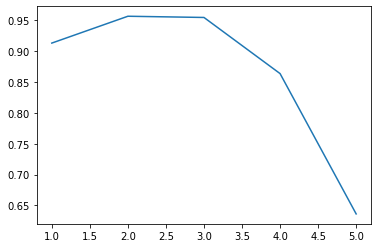

In [24]:
plt.plot(range(1,6),scores);

### ADABoost Regression

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor
#### Parameters

* base estimator: Default: DecisionTreeRegressor(max_depth = 3)
* n_estimators: number of estimators
* learning_rate

https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#sphx-glr-auto-examples-ensemble-plot-adaboost-regression-py

In [5]:
Boston = pd.read_csv("Boston.csv")
X = Boston.iloc[:, 0:13].values
y = Boston.iloc[:, 13].values
feats = Boston.columns.tolist()[0:13]

# Validation Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

#### Compare Decision Tree with ADABoost

In [6]:
dt = DecisionTreeRegressor(random_state = 12)
dt.fit(X_train,y_train)
yhat = dt.predict(X_test)
mse = np.mean(y_test - yhat)**2
print(f'MSE: {np.round(mse,3)} R2: {np.round(dt.score(X_test,y_test),3)}')

MSE: 0.075 R2: 0.677


In [7]:
ada_regress = AdaBoostRegressor(dt,n_estimators = 500,
                                learning_rate = 1.0,
                                random_state = 42)
ada_regress.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=12),
                  n_estimators=500, random_state=42)

In [8]:
yhat = ada_regress.predict(X_test)
mse = np.mean(y_test - yhat)**2
print(f'MSE: {np.round(mse,3)} R2: {np.round(ada_regress.score(X_test,y_test),3)}')

MSE: 0.249 R2: 0.832


#### Use Linear Regression as an estimator rather than Decision Tree Regressor

In [10]:
ada_regress = AdaBoostRegressor(n_estimators = 700,
                                learning_rate = 1.0,
                                random_state = 4)
ada_regress.fit(X_train,y_train)
yhat = ada_regress.predict(X_test)
mse = np.mean(y_test - yhat)**2
print(f'MSE: {np.round(mse,3)} R2: {np.round(ada_regress.score(X_test,y_test),3)}')

MSE: 0.35 R2: 0.785


In [11]:
lr = LinearRegression()
lr.fit(X_train,y_train)
yhat = lr.predict(X_test)
mse = np.mean(y_test - yhat)**2
print(f'MSE: {np.round(mse,3)} R2: {np.round(lr.score(X_test,y_test),3)}')

MSE: 0.095 R2: 0.684


### References

Patrick Winston: Learning Boosting, https://www.youtube.com/watch?v=UHBmv7qCey4&t=1636s